In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import os
from zipfile import ZipFile
from PIL import Image
from skimage import color
from datasets import load_dataset
from dotenv import load_dotenv
import os
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import dataset
from visualize import *
import torch
from torch import nn
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available()
                else "mps" if torch.backends.mps.is_built() else "cpu")
print(f"Device: {device}")

/home/prio/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## TODO: use this loss as style loss

import lpips
perceptual_loss_fn = lpips.LPIPS(net='alex').to(device)
# d = loss_fn.forward(im0,im1)


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/prio/miniconda3/lib/python3.12/site-packages/lpips/weights/v0.1/alex.pth
cuda


### Architecture

In [3]:
class Adain_Encoder(nn.Module):
    def __init__(self, in_channels, out_dim):
        super(Adain_Encoder, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)
        self.conv5 = nn.Conv2d(512, out_dim, kernel_size=3, stride=2, padding=1)
        
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = torch.relu(self.conv5(x))
        
        # Global average pooling
        x = self.global_avg_pool(x)        
        # Flatten
        x = x.view(x.size(0), -1)
        
        return x

# Example usage:
# Define input and output dimensions
in_channels = 3  # number of input channels
out_dim = 128  # size of the output representation

# Create an instance of the ConvNet
model = Adain_Encoder(in_channels, out_dim)

# Create a random input tensor
input_tensor = torch.randn(4, in_channels, 256, 256)

# Forward pass
output = model(input_tensor)

print("Output shape:", output.shape)


Output shape: torch.Size([4, 128])


In [4]:
import torch.nn.init as init

class AdaIN_interface(nn.Module):
    
    def __init__(self, style_dim, channels):
        super(AdaIN_interface, self).__init__()
        self.instance_norm = nn.InstanceNorm2d(channels, affine=False)
        self.style_scale_transform = nn.Linear(style_dim, channels)
        self.style_shift_transform = nn.Linear(style_dim, channels)

        ## to ensure they learn different stuff | How tho?
        init.normal_(self.style_scale_transform.weight, mean=1.0, std=0.02)
        init.normal_(self.style_shift_transform.weight, mean=0.0, std=0.02)

        self.style_scale_transform.bias.data.fill_(1)  # Initialize scale to 1
        self.style_shift_transform.bias.data.fill_(0)  # Initialize shift to 0

    def forward(self, x, encoded_style):
        '''
        x - feature maps from the unet
        y - learned (jointly) from encoder

        return:
        same size as x
        '''
        # Normalize the input feature map
        normalized = self.instance_norm(x)
        
        # Extract style scale and shift parameters from the style vector
        scale = self.style_scale_transform(style)[:, :, None, None]
        shift = self.style_shift_transform(style)[:, :, None, None]
        
        # Apply scale and shift to the normalized feature map
        transformed = scale * normalized + shift
        
        return transformed

# Example usage:
# Define the dimensions
style_dim = 128  # dimensionality of the style vector
channels = 256    # number of channels in the feature map

# Create an instance of AdaIN
adain = AdaIN_interface(style_dim, channels)

# Generate random input feature map and style vector
x = torch.randn(4, channels, 64, 64)  # Example input feature map
style = torch.randn(1, style_dim)     # Example style vector

# Apply AdaIN

output = adain(x, style)

print("Output shape:", output.shape)


Output shape: torch.Size([4, 256, 64, 64])


In [5]:
OUT_VEC_DIM = 128

class UNet(nn.Module):
    def __init__(self, in_C = 3, out_C=3, style_dim=128):
        super(UNet, self).__init__()

        # Encoder
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_C, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )
        self.maxpool_1to2 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
        )
        self.maxpool_2to3 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
        )
        self.maxpool_3to4 = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
        )
        self.maxpool_4to5 = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
        )

        # Decoder
        self.conv_transpose_5to6 = nn.ConvTranspose2d(512, 512, 4, stride=2, padding=1)
        self.conv1d_fusing_5to6 = nn.Conv2d(1024, 512, 1)
        self.conv6 = nn.Sequential(
            nn.Conv2d(512, 256, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
        )
        self.conv_transpose_6to7 = nn.ConvTranspose2d(256, 256, 4, stride=2, padding=1)
        self.conv1d_fusing_6to7 = nn.Conv2d(512, 256, 1)
        self.conv7 = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
        )
        self.conv_transpose_7to8 = nn.ConvTranspose2d(128, 128, 4, stride=2, padding=1)
        self.conv1d_fusing_7to8 = nn.Conv2d(256, 128, 1)
        self.conv8 = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )
        self.conv_transpose8to9 = nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1)
        self.conv1d_fusing_8to9 = nn.Conv2d(128, 64, 1)
        self.conv9 = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1),      # Simmetry broken here: keeps being 64 (from paper)
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )
        self.conv10 = nn.Conv2d(64, out_C, 1)

        '''
        Conv1 shape torch.Size([16, 64, 128, 128])
        Conv2 shape torch.Size([16, 128, 64, 64])
        Conv3 shape torch.Size([16, 256, 32, 32])
        Conv4 shape torch.Size([16, 512, 16, 16])
        Conv5 shape torch.Size([16, 512, 8, 8])
        '''

        # AdaIN interface layers
        ## Encoder side
        self.encoder_adain1 = AdaIN_interface(OUT_VEC_DIM, 64)
        self.encoder_adain2 = AdaIN_interface(OUT_VEC_DIM, 128)
        self.encoder_adain3 = AdaIN_interface(OUT_VEC_DIM, 256)
        self.encoder_adain4 = AdaIN_interface(OUT_VEC_DIM, 512)
        ## Bottleneck
        self.encoder_adain5 = AdaIN_interface(OUT_VEC_DIM, 512)
        ## Decoder side
        self.decoder_adain4 = AdaIN_interface(OUT_VEC_DIM, 512)
        self.decoder_adain3 = AdaIN_interface(OUT_VEC_DIM, 256)
        self.decoder_adain2 = AdaIN_interface(OUT_VEC_DIM, 128)
        self.decoder_adain1 = AdaIN_interface(OUT_VEC_DIM, 64)

        if out_C == 3:
            self.style_encoder = Adain_Encoder(in_channels=3, out_dim=style_dim)
        elif out_C == 2:
            self.style_encoder = Adain_Encoder(in_channels=2, out_dim=style_dim)


    def forward(self,x,style_image):
        x=x.to(device)
        style_image = style_image.to(device)

        encoded_style = self.style_encoder(style_image).to(device)

        # Encoder
        conv1 = self.conv1(x)
        conv1 = self.encoder_adain1(x,encoded_style) ## AdaIN normalization applied

        maxpooled_1to2 = self.maxpool_1to2(conv1)
        conv2 = self.conv2(maxpooled_1to2)
        conv2 = self.encoder_adain2(conv2,encoded_style) ## AdaIN normalization applied

        maxpooled_2to3 = self.maxpool_2to3(conv2)
        conv3 = self.conv3(maxpooled_2to3)
        conv3 = self.encoder_adain3(conv3,encoded_style) ## AdaIN normalization applied

        maxpooled_3to4 = self.maxpool_3to4(conv3)
        conv4 = self.conv4(maxpooled_3to4)
        conv4 = self.encoder_adain4(conv4,encoded_style) ## AdaIN normalization applied

        maxpooled_4to5 = self.maxpool_4to5(conv4)
        conv5 = self.conv5(maxpooled_4to5)
        conv5 = self.encoder_adain5(conv5,encoded_style) ## AdaIN normalization applied

        # Decoder
        conv_transpose_6 = self.conv_transpose_5to6(conv5)
        conv_transpose_6 = self.decoder_adain4(conv_transpose_6,encoded_style) ## AdaIN normalization applied
        concatenation_5to6 = torch.cat((conv4, conv_transpose_6),1)
        skip_fusion_5to6 = self.conv1d_fusing_5to6(concatenation_5to6)
        conv6 = self.conv6(skip_fusion_5to6)

        conv_transpose_7 = self.conv_transpose_6to7(conv6)
        conv_transpose_7 = self.decoder_adain3(conv_transpose_7,encoded_style) ## AdaIN normalization applied
        concatenation_6to7 = torch.cat((conv3, conv_transpose_7),1)
        skip_fusion_6to7 = self.conv1d_fusing_6to7(concatenation_6to7)
        conv7 = self.conv7(skip_fusion_6to7)

        conv_transpose_8 = self.conv_transpose_7to8(conv7)
        conv_transpose_8 = self.decoder_adain2(conv_transpose_8,encoded_style) ## AdaIN normalization applied
        concatenation_7to8 = torch.cat((conv2, conv_transpose_8),1)
        skip_fusion_7to8 = self.conv1d_fusing_7to8(concatenation_7to8)
        conv8 = self.conv8(skip_fusion_7to8)

        conv_transpose_9 = self.conv_transpose8to9(conv8)
        conv_transpose_9 = self.decoder_adain1(conv_transpose_9,encoded_style) ## AdaIN normalization applied
        concatenation_8_to9 = torch.cat((conv1, conv_transpose_9),1)
        skip_fusion_8to9 = self.conv1d_fusing_8to9(concatenation_8_to9)
        conv9 = self.conv9(skip_fusion_8to9)
    

        output = self.conv10(conv9)
        return output

    def train_model(self, train_loader, val_loader, 
                    epochs=54, 
                    lr=0.0001, 
                    loss_fn=nn.MSELoss(), 
                    optimizer=torch.optim.Adam, 
                    verbose=True, 
                    save_path = "./model_storage/", 
                    save_name_prefix='/',
                    colorspace='RGB'):

        '''
        save_path = folder for saving results
        save_name_prefix = prefix for saved files to mark experiments (start with '/')


        '''

        loss_df = pd.DataFrame(['training_loss', 'validation_loss'])
        self = self.to(device)
        self.train()
        optimizer = optimizer(self.parameters(), lr=lr)

        #for saving progress
        best_val_loss = 99999
        val_loss_list = []
        training_loss_list = []

        for epoch in tqdm(range(epochs)):
            training_loss = 0
            for i, batch_data in enumerate(train_loader):
                image = batch_data['grayscale_image']
                image = image.to(device)
    
                input_encoder = batch_data['image']
                input_encoder = input_encoder.to(device)

                optimizer.zero_grad()
    
                reproduced_image = self(image,input_encoder)
                reproduced_image = reproduced_image.to(device)
                ## aici trebuie comparat doar cu canalele ab
                if colorspace == 'RGB':
                    loss = loss_fn(reproduced_image, batch_data['image'].to(device))
                elif colorspace == 'LAB':
                    loss = loss_fn(reproduced_image, batch_data['image'][:,1:,:,:].to(device))
                training_loss += loss.item()
                loss.backward()
                optimizer.step()

            #average training loss
            training_loss /= len(train_loader)
            training_loss_list.append(training_loss)


            if (epoch)%5 == 0 or (epoch + 1) == epochs:
                val_loss = 0.0  # Track validation loss
                with torch.no_grad():  # Disable gradient calculation for validation
                    for val_data in val_loader:
                        val_image = val_data['grayscale_image']
                        val_image = val_image.to(device)

                        input_encoder = val_data['image']
                        input_encoder = input_encoder.to(device)


                        val_reproduced_image = self(val_image,input_encoder)
                        val_reproduced_image = val_reproduced_image.to(device)
                        if colorspace == 'RGB':
                            val_loss += loss_fn(val_reproduced_image, val_data['image'].to(device)).item()
                        elif colorspace == 'LAB':
                            val_loss += loss_fn(val_reproduced_image, val_data['image'][:,1:,:,:].to(device)).item()
                       
                val_loss /= len(val_loader)  # Calculate average validation loss
                val_loss_list.append(val_loss)

                if verbose:
                  print(f"Epoch {epoch}, training_loss = {training_loss}")
                  print(f"Epoch {epoch}: validation loss = {val_loss}")


                if val_loss < best_val_loss:  # Update best validation loss and save checkpoint if best model
                  state_diction = self.state_dict()
                  best_val_loss = val_loss
                  for key in state_diction.keys():
                      state_diction[key] = state_diction[key].to(torch.device('cpu'))
                  torch.save(state_diction, (save_path+save_name_prefix+f"UNet_best_model.pth.tar"))

                #construct df with losses
                loss_df = pd.DataFrame({'epoch': range(0,epoch+1),  'training_loss':training_loss_list, 'val_loss': val_loss_list})
                loss_df.to_csv(save_path+save_name_prefix+"UNet_loss.csv", index=False)
                # plot losses
                plt.plot(loss_df['epoch'], loss_df['training_loss'], label='Training Loss')
                plt.plot(loss_df['epoch'], loss_df['val_loss'].interpolate(method='linear'), label='Validation Loss')
                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                plt.title('Training and Validation Loss')
                plt.legend()

                # Save plot as .png file
                plt.savefig(save_path+save_name_prefix+'UNet_loss_plot.png')
                plt.clf()
            else:
              val_loss_list.append(np.nan)


In [6]:
def load_model_from_checkpoint(checkpoint_path):
    if os.path.exists(checkpoint_path):
        # Load the checkpoint
        checkpoint = torch.load(checkpoint_path)
        
        # Create model architecture
        # For example, if your model class is named MyModel:
        model = UNet(in_C=1, out_C=3)
        
        # Load state_dict into the model
        model.load_state_dict(checkpoint)
        
        # Optionally, load other elements from the checkpoint such as optimizer state, etc.
        # optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
        print("Model loaded successfully from checkpoint.")
        return model.to(device)
    else:
        print("Checkpoint file does not exist.")
        return None


In [7]:
mse_loss_fn = nn.MSELoss()
def perceptual_and_MSE_loss(reproduced_image, original_image):
    '''
    reproduced_image: output of the model
    original_image: ground truth
    '''
    # Perceptual loss
    perceptual_loss = perceptual_loss_fn(reproduced_image, original_image).mean()
    
    # MSE loss
    mse_loss = mse_loss_fn(reproduced_image, original_image)
    
    return perceptual_loss + mse_loss

### Colorization from RGB color space. 

Input is a HxW grayscale image.
Output is a 3xHxW RGB image.

No std and mean normalization is used.

In [8]:
TRAIN_SIZE = 100
VAL_SIZE = 150
BATCH_SIZE = 16

train_data, validation_data = dataset.prepare_dataset(train_size=TRAIN_SIZE, test_size=VAL_SIZE, batch_size=BATCH_SIZE,colorspace='RGB',resolution=(128,128))
train_loader, validation_loader = dataset.prepare_dataloader(train_data, validation_data, batch_size=BATCH_SIZE)


'''
Since the model is trained against 3XHxW RGB images I expect the order of the channels in the ouput to be the same
'''

Dataset loaded successfully
Data loader prepared successfully


'\nSince the model is trained against 3XHxW RGB images I expect the order of the channels in the ouput to be the same\n'

In [9]:
TRAIN = True

In [10]:
print("Device is: ", device)
model = UNet(in_C=1, out_C=3).to(device)

if TRAIN:
    model.train_model(train_loader=train_loader, val_loader=validation_loader, epochs=2, lr=0.0001, loss_fn=perceptual_and_MSE_loss, optimizer=torch.optim.Adam, verbose=True, save_path= 'combined_losses_experiments/', save_name_prefix='/unet')
    state_diction = model.state_dict()

    for key in state_diction.keys():
        state_diction[key] = state_diction[key].to(torch.device('cpu'))

    torch.save(state_diction, "unet_adain_combined_losses.pth.tar")
else:
    model = load_model_from_checkpoint("/Users/matteom/shared-folder/artistic-colorization-UNet/Unet_adain/model_storage/UNet-AdaIN_trsize1200-epoch57.pth.tar")
    model = model.to(device)

Device is:  cuda


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0, training_loss = 1.4284243753978185
Epoch 0: validation loss = 1.1791816830635071


 50%|█████     | 1/2 [00:06<00:06,  6.27s/it]

Epoch 1, training_loss = 1.0425454889025008
Epoch 1: validation loss = 0.8882159173488617


100%|██████████| 2/2 [00:10<00:00,  5.33s/it]


<Figure size 640x480 with 0 Axes>

#### Style analysis

In [11]:
training_data_list = list(train_data)

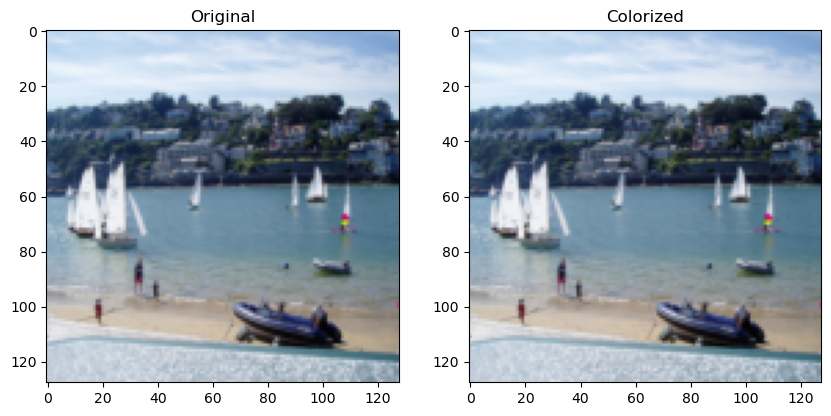

In [12]:
input_encoder_style = training_data_list[38]['image']

## plot reference style
plot_both(input_encoder_style.permute(1,2,0).numpy(),input_encoder_style.permute(1,2,0).numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


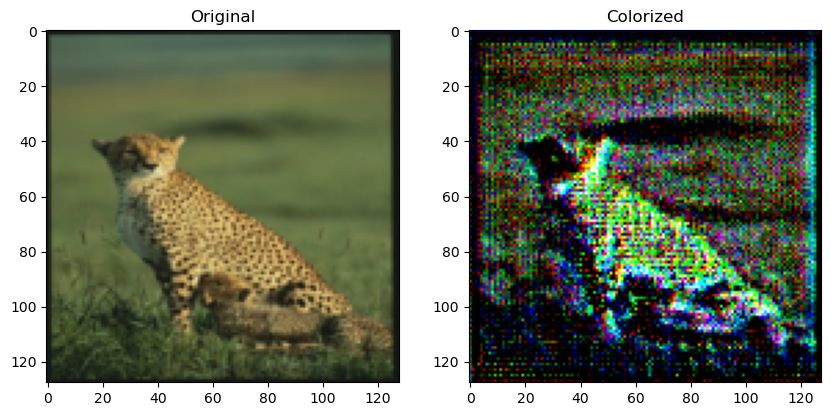

In [13]:
## style is the image itself
entry = training_data_list[39]
input_unet = entry['grayscale_image']
input_encoder = entry['image']

output = model(input_unet.unsqueeze(0).to(device), input_encoder.unsqueeze(0).to(device))
output = output.detach().cpu().squeeze(0)
# plot_both(input_encoder.permute(1,2,0).numpy(),output.permute(1,2,0).numpy(),save_name="results/butterfly.png")

plot_both(input_encoder.permute(1,2,0).numpy(),output.permute(1,2,0).numpy(),save_name="results_combined_loss/leopard_no_style.png")

# plot_both(input_encoder.permute(1,2,0).numpy(),output.permute(1,2,0).numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


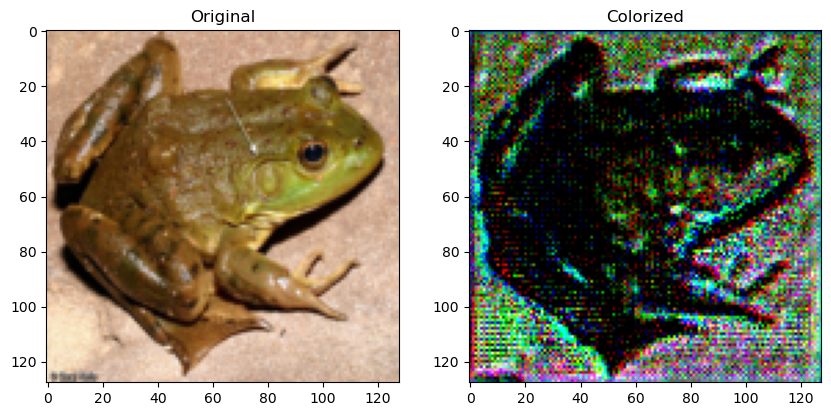

In [14]:
## style is the image itself
entry = training_data_list[32]
input_unet = entry['grayscale_image']
input_encoder = entry['image']

output = model(input_unet.unsqueeze(0).to(device), input_encoder.unsqueeze(0).to(device))
output = output.detach().cpu().squeeze(0)
plot_both(entry['image'].permute(1,2,0).numpy(),output.permute(1,2,0).numpy())


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


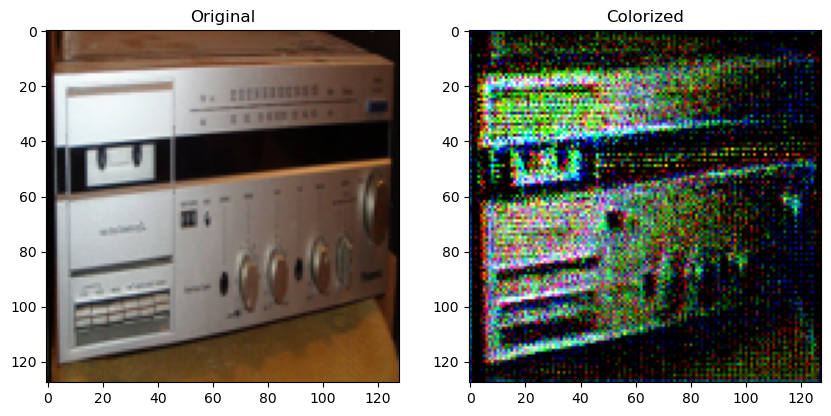

In [15]:
## style is the style image
entry = training_data_list[19]
input_unet = entry['grayscale_image']
input_encoder = input_encoder_style
input_encoder = entry['image']
output = model(input_unet.unsqueeze(0).to(device), input_encoder.unsqueeze(0).to(device))
output = output.detach().cpu().squeeze(0)
plot_both(entry['image'].permute(1,2,0).numpy(),output.permute(1,2,0).numpy())


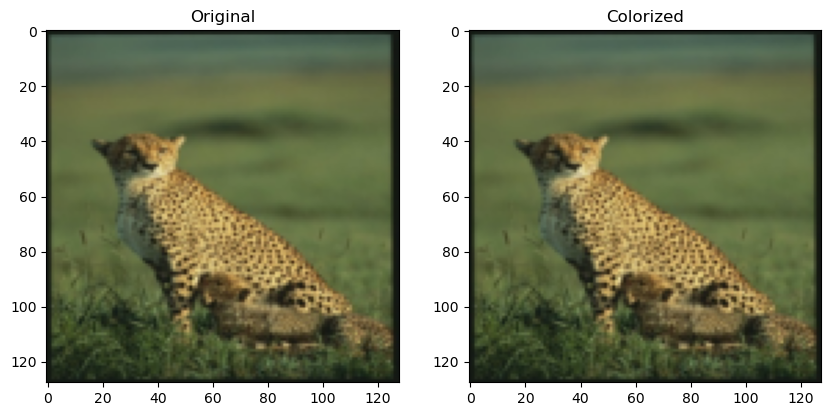

In [16]:
reference_style = training_data_list[39]['image']
plot_both(reference_style.permute(1,2,0).numpy(),reference_style.permute(1,2,0).numpy())


### Colorization from LAB color space. 

Input is a HxW grayscale image (the l channel).
Output is 2xHxW representing the ab channels.

No std and mean normalization is used.

In [ ]:
# TRAIN_SIZE = 600
# VAL_SIZE = 150
# BATCH_SIZE = 16

# train_data, validation_data = dataset.prepare_dataset(train_size=TRAIN_SIZE, test_size=VAL_SIZE, batch_size=BATCH_SIZE,colorspace='LAB')
# train_loader, validation_loader = dataset.prepare_dataloader(train_data, validation_data, batch_size=BATCH_SIZE)


# '''
# Since the model is trained against 3XHxW RGB images I expect the order of the channels in the ouput to be the same
# '''

In [ ]:
# model = UNet(in_C=1, out_C=2)

In [ ]:
# model.train_model(train_loader=train_loader, val_loader=validation_loader, 
#                   epochs=55, 
#                   lr=0.0001, 
#                   loss_fn=nn.MSELoss(), 
#                   optimizer=torch.optim.Adam, 
#                   verbose=True, 
#                   save_path= 'experiment_results/LAB_55ep_600', 
#                   save_name_prefix='/1000_training_',
#                   colorspace='LAB')

In [ ]:

visualize(list(train_data)[32],model,lab=True)

In [ ]:

visualize(list(train_data)[19],model,lab=True)

In [ ]:

visualize(list(train_data)[42],model,lab=True)

In [ ]:

visualize(list(train_data)[43],model,lab=True)

In [ ]:
## must have length 8!
images_to_visualize_indexes = [3,12,5,17,11,3,28,29]

visualization_images = get_visualization_images(images_to_visualize_indexes)
outputs = get_batch_outputs(visualization_images)
plot_grid(visualization_images, outputs)